## Cloning model & installing dependencies

In [ ]:
# !git clone https://github.com/ultralytics/yolov5  # clone repo
# !pip install -U -r yolov5/requirements.txt  # install dependencies

/content/gdrive/My Drive/Kaggle


## Importing libs

In [ ]:
import numpy as np
import torch
from google.colab import drive
import os
import zipfile 
import yaml

## Linking kaggle dataset to drive 

In [ ]:
!pip install kaggle

In [ ]:
drive.mount('/content/gdrive')
os.environ['KAGGLE_CONFIG_DIR'] = '/content/gdrive/My Drive/Kaggle'

Mounted at /content/gdrive


In [ ]:
%cd /content/gdrive/My\ Drive/Kaggle
%ls

/content/gdrive/My Drive/Kaggle
 annotations/   images/      'Safety Helmet Detection'/
 horse2zebra/   kaggle.json   yolov5/


In [ ]:
!rm -r Safety\ Helmet\ Detection

In [ ]:
!kaggle datasets download -d andrewmvd/hard-hat-detection

hard-hat-detection.zip: Skipping, found more recently modified local copy (use --force to force download)


In [ ]:
!unzip \*.zip 
print('Unzipping successfully finished')

Archive:  hard-hat-detection.zip
replace annotations/hard_hat_workers0.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: no
replace annotations/hard_hat_workers1.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: Unzipping successfully finished


## Splitting data 

In [ ]:
# Creating directories for splitting purpose
%cd /content/gdrive/My Drive/Kaggle
if os.path.exists('Safety Helmet Detection'):
  print('Directories already exist')
else:
  os.mkdir('Safety Helmet Detection')
  os.mkdir('Safety Helmet Detection/training')
  os.mkdir('Safety Helmet Detection/validation')

/content/gdrive/My Drive/Kaggle


In [ ]:
df = os.listdir('/content/gdrive/My Drive/Kaggle/images')
data_len = len(df)
SPLIT_SIZE_ = int(0.8*data_len)

np.random.shuffle(df)

train_data = df[:SPLIT_SIZE_]
val_data = df[SPLIT_SIZE_:]

In [ ]:
data_len

5000

In [ ]:
import shutil

imgs_path = '/content/gdrive/My Drive/Kaggle/images/'
annot_path = '/content/gdrive/My Drive/Kaggle/annotations/'

for img in train_data:

  img_src = os.path.join(imgs_path, img)
  anot_src = os.path.join(annot_path, img.split('.')[0] + '.xml')
  shutil.copy(img_src,'/content/gdrive/My Drive/Kaggle/Safety Helmet Detection/training')
  shutil.copy(anot_src,'/content/gdrive/My Drive/Kaggle/Safety Helmet Detection/training')

for img in val_data:

  img_src = os.path.join(imgs_path, img)
  anot_src = os.path.join(annot_path, img.split('.')[0] + '.xml')
  shutil.copy(img_src,'/content/gdrive/My Drive/Kaggle/Safety Helmet Detection/validation')
  shutil.copy(anot_src,'/content/gdrive/My Drive/Kaggle/Safety Helmet Detection/validation')

In [ ]:
# Insepcting directories
%cd 'Safety Helmet Detection/training'
%ls

/content/gdrive/My Drive/Kaggle/Safety Helmet Detection/training
hard_hat_workers0.png     hard_hat_workers249.xml   hard_hat_workers4022.png
hard_hat_workers0.xml     hard_hat_workers24.png    hard_hat_workers4022.xml
hard_hat_workers1000.png  hard_hat_workers24.xml    hard_hat_workers4023.png
hard_hat_workers1000.xml  hard_hat_workers2500.png  hard_hat_workers4023.xml
hard_hat_workers1001.png  hard_hat_workers2500.xml  hard_hat_workers4025.png
hard_hat_workers1001.xml  hard_hat_workers2501.png  hard_hat_workers4025.xml
hard_hat_workers1003.png  hard_hat_workers2501.xml  hard_hat_workers4026.png
hard_hat_workers1003.xml  hard_hat_workers2503.png  hard_hat_workers4026.xml
hard_hat_workers1004.png  hard_hat_workers2503.xml  hard_hat_workers4027.png
hard_hat_workers1004.xml  hard_hat_workers2504.png  hard_hat_workers4027.xml
hard_hat_workers1006.png  hard_hat_workers2504.xml  hard_hat_workers4028.png
hard_hat_workers1006.xml  hard_hat_workers2505.png  hard_hat_workers4028.xml
hard_hat_wo

## Converting annotations to YOLO_v5 format

In [ ]:
import glob
import pickle
import xml.etree.ElementTree as ET
from os import listdir, getcwd
from os.path import join

dirs = ['training', 'validation']
classes = ['helmet', 'person', 'head']

def getImagesInDir(dir_path):
   image_list = []
   for filename in glob.glob(dir_path + '/*.png'):
       image_list.append(filename)
   return image_list

def convert(size, box):
    dw = 1./(size[0])
    dh = 1./(size[1])
    x = (box[0] + box[1])/2.0 - 1
    y = (box[2] + box[3])/2.0 - 1
    w = box[1] - box[0]
    h = box[3] - box[2]
    x = x*dw
    w = w*dw
    y = y*dh
    h = h*dh
    return (x,y,w,h)

def convert_annotation(dir_path, output_path, image_path):
    basename = os.path.basename(image_path)
    basename_no_ext = os.path.splitext(basename)[0]

    in_file = open(dir_path + '/' + basename_no_ext + '.xml')
    out_file = open(output_path + basename_no_ext + '.txt', 'w')

    tree = ET.parse(in_file)
    root = tree.getroot()
    size = root.find('size')
    w = int(size.find('width').text)
    h = int(size.find('height').text)
    for obj in root.iter('object'):
       difficult = obj.find('difficult').text
       cls = obj.find('name').text
       if cls not in classes or int(difficult)==1:
           continue
       cls_id = classes.index(cls)
       xmlbox = obj.find('bndbox')
       
       b = (float(xmlbox.find('xmin').text), float(xmlbox.find('xmax').text),float(xmlbox.find('ymin').text),float(xmlbox.find('ymax').text))
       bb = convert((w,h), b)
       out_file.write(str(cls_id) + " " + " ".join([str(a) for a in bb]) + '\n')

cwd = '/content/gdrive/My Drive/Kaggle/Safety Helmet Detection'

for dir_path in dirs:
    full_dir_path = os.path.join(cwd, dir_path)
    output_path = full_dir_path + '/'  

    if not os.path.exists(output_path):
        os.makedirs(output_path)

    image_paths = getImagesInDir(full_dir_path)
    print('Len of image_paths', len(image_paths))

    list_file = open(full_dir_path + '.txt', 'w')

    for image_path in image_paths:
        list_file.write(image_path + '\n')     
        convert_annotation(full_dir_path, output_path, image_path)
    
    list_file.close()

    print("Finished processing: " + dir_path)

Len of image_paths 4000
Finished processing: training
Len of image_paths 1000
Finished processing: validation


## Define YOLOv5 Model Configuration And Architecture

In [ ]:
# YAML file
path = '/content/gdrive/My Drive/Kaggle/Safety Helmet Detection/'
yaml_file = open(path + 'data.yaml', 'w+')
yaml_file.write('train: ' + path + 'training.txt' + '\n')
yaml_file.write('val: ' + path + 'validation.txt\n' + '\n')
yaml_file.write('nc: ' + str(len(classes)) + '\n')
yaml_file.write('names: ' + "['helmet', 'person', 'head']" )

35

In [ ]:
%cat /content/gdrive/My\ Drive/Kaggle/Safety\ Helmet\ Detection/data.yaml

train: /content/gdrive/My Drive/Kaggle/Safety Helmet Detection/training.txt
val: /content/gdrive/My Drive/Kaggle/Safety Helmet Detection/validation.txt

nc: 3
names: ['helmet', 'person', 'head']

## Editing model .yaml file

In [ ]:
file_path = '/content/yolov5/models'

with open(file_path + '/yolov5l.yaml', 'r+') as yolo_f: 
    for l in yolo_f:
      print(l)

[Errno 2] No such file or directory: '/content/gdrive/My Drive/Kaggle/yolov5/models'
/content/yolov5
# parameters

nc: 3  # number of classes

depth_multiple: 1.0  # model depth multiple

width_multiple: 1.0  # layer channel multiple



# anchors

anchors:

  - [10,13, 16,30, 33,23]  # P3/8

  - [30,61, 62,45, 59,119]  # P4/16

  - [116,90, 156,198, 373,326]  # P5/32



# YOLOv5 backbone

backbone:

  # [from, number, module, args]

  [[-1, 1, Focus, [64, 3]],  # 0-P1/2

   [-1, 1, Conv, [128, 3, 2]],  # 1-P2/4

   [-1, 3, BottleneckCSP, [128]],

   [-1, 1, Conv, [256, 3, 2]],  # 3-P3/8

   [-1, 9, BottleneckCSP, [256]],

   [-1, 1, Conv, [512, 3, 2]],  # 5-P4/16

   [-1, 9, BottleneckCSP, [512]],

   [-1, 1, Conv, [1024, 3, 2]],  # 7-P5/32

   [-1, 1, SPP, [1024, [5, 9, 13]]],

   [-1, 3, BottleneckCSP, [1024, False]],  # 9

  ]



# YOLOv5 head

head:

  [[-1, 1, Conv, [512, 1, 1]],

   [-1, 1, nn.Upsample, [None, 2, 'nearest']],

   [[-1, 6], 1, Concat, [1]],  # cat backbone P4

   

In [ ]:
print(torch.cuda.is_available())
print(yaml.__version__)


True
5.3.1


## Training model

In [ ]:
%cd /content/gdrive/My\ Drive/Kaggle/yolov5/
%pwd
!python train.py --img 416 --batch 32 --epochs 30 --data ../Safety\ Helmet\ Detection/data.yaml --cfg models/yolov5l.yaml --weights weights/results_yolov5l.txt --device 0

/content/gdrive/My Drive/Kaggle/yolov5
Using CUDA device0 _CudaDeviceProperties(name='Tesla T4', total_memory=15079MB)

Namespace(adam=False, batch_size=32, bucket='', cache_images=False, cfg='models/yolov5l.yaml', data='../Safety Helmet Detection/data.yaml', device='0', epochs=30, evolve=False, global_rank=-1, hyp='data/hyp.scratch.yaml', image_weights=False, img_size=[416, 416], local_rank=-1, logdir='runs/', multi_scale=False, name='', noautoanchor=False, nosave=False, notest=False, rect=False, resume=False, single_cls=False, sync_bn=False, total_batch_size=32, weights='weights/results_yolov5l.txt', workers=8, world_size=1)
Start Tensorboard with "tensorboard --logdir runs/", view at http://localhost:6006/
2020-10-02 05:53:33.860429: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1
Hyperparameters {'lr0': 0.01, 'lrf': 0.2, 'momentum': 0.937, 'weight_decay': 0.0005, 'warmup_epochs': 3.0, 'warmup_momentum': 0.8, 'war

## Visualizing results

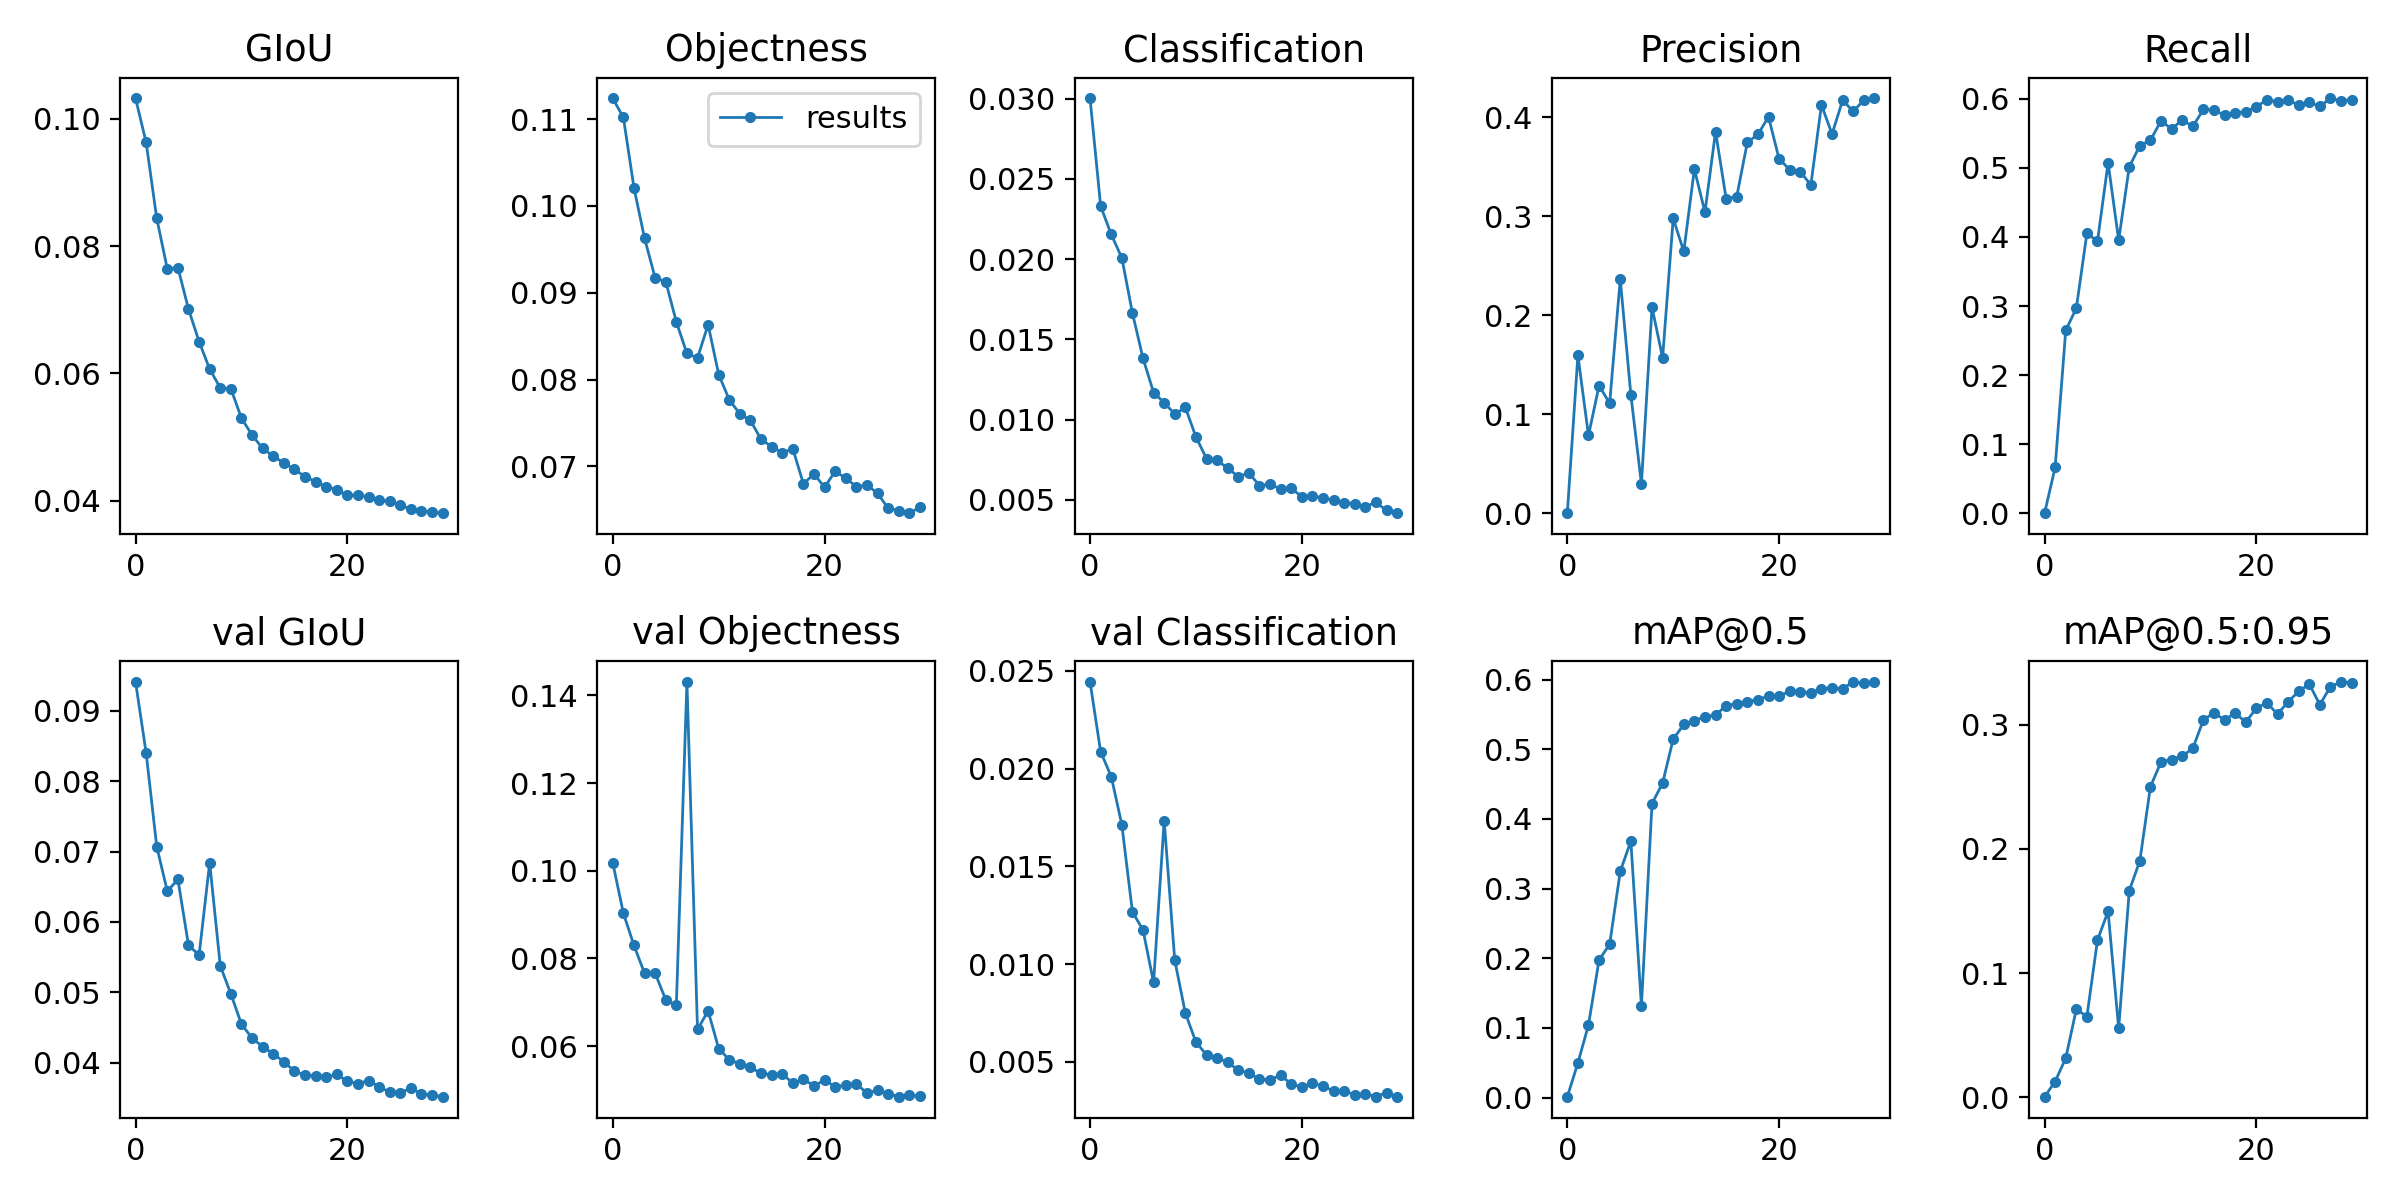

In [ ]:
from PIL import Image
res = Image.open('/content/gdrive/My Drive/Kaggle/yolov5/runs/exp1/results.png')
batch_img = Image.open('/content/gdrive/My Drive/Kaggle/yolov5/runs/exp1/train_batch1.jpg')
res

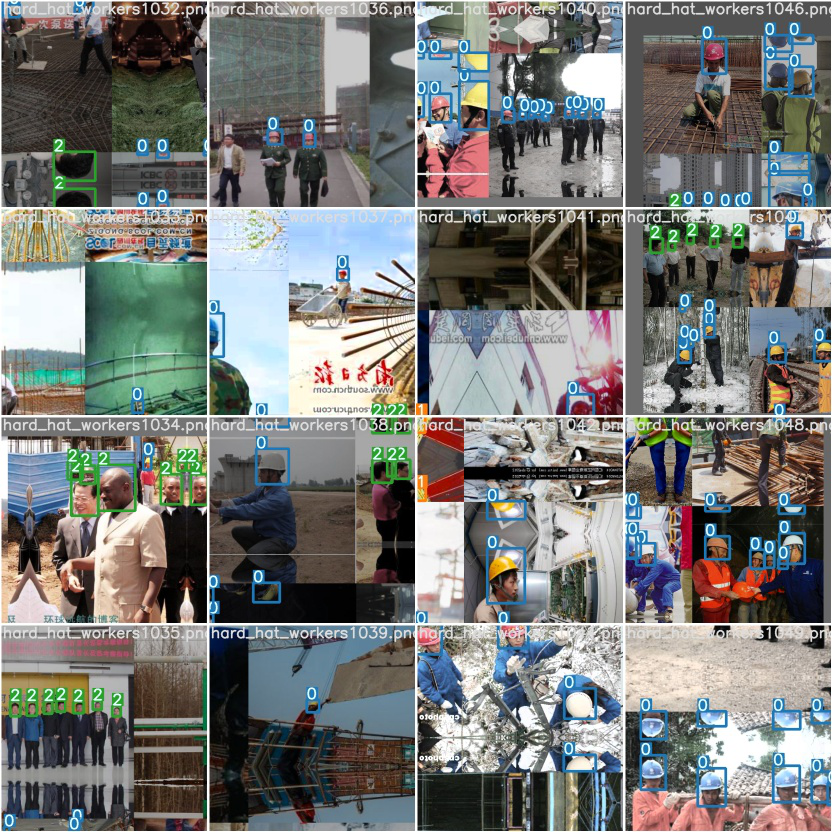

In [ ]:
batch_img

## Inference 

In [ ]:
%cd /content/gdrive/My\ Drive/Kaggle/yolov5/
!python3 detect.py --source inference/images/helmet_test1.jpeg  --weights runs/exp1/weights/last.pt --conf 0.5

/content/gdrive/My Drive/Kaggle/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.5, device='', img_size=640, iou_thres=0.5, output='inference/output', save_txt=False, source='inference/images/helmet_test1.jpeg', update=False, view_img=False, weights=['runs/exp1/weights/last.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... 
Model Summary: 335 layers, 4.74041e+07 parameters, 0 gradients
image 1/1 /content/gdrive/My Drive/Kaggle/yolov5/inference/images/helmet_test1.jpeg: 512x640 3 helmets, Done. (0.034s)
Results saved to inference/output
Done. (2.091s)


In [ ]:
img = Image.open('/content/gdrive/My Drive/Kaggle/yolov5/inference/output/helmet_test1.jpeg')
img

In [ ]:
%cd /content/gdrive/My\ Drive/Kaggle/yolov5/
!python3 detect.py --source inference/images/test_video.mp4 --weights runs/exp1/weights/last.pt 

/content/gdrive/My Drive/Kaggle/yolov5
Namespace(agnostic_nms=False, augment=False, classes=None, conf_thres=0.4, device='', img_size=640, iou_thres=0.5, output='inference/output', save_txt=False, source='inference/images/test_video.mp4', update=False, view_img=False, weights=['runs/exp1/weights/last.pt'])
Using CUDA device0 _CudaDeviceProperties(name='Tesla P100-PCIE-16GB', total_memory=16280MB)

Fusing layers... 
Model Summary: 335 layers, 4.74041e+07 parameters, 0 gradients
video 1/1 (1/1826) /content/gdrive/My Drive/Kaggle/yolov5/inference/images/test_video.mp4: 384x640 Done. (0.028s)
video 1/1 (2/1826) /content/gdrive/My Drive/Kaggle/yolov5/inference/images/test_video.mp4: 384x640 Done. (0.027s)
video 1/1 (3/1826) /content/gdrive/My Drive/Kaggle/yolov5/inference/images/test_video.mp4: 384x640 Done. (0.027s)
video 1/1 (4/1826) /content/gdrive/My Drive/Kaggle/yolov5/inference/images/test_video.mp4: 384x640 Done. (0.027s)
video 1/1 (5/1826) /content/gdrive/My Drive/Kaggle/yolov5/infe